##Part 2 - Advanced Model Analysis, Optimization, and Conclusions

Introduction
In Part 2 of this project, the focus is on improving the baseline regression model developed in Part 1.
This involves addressing errors identified during the error analysis, enhancing the model pipeline through preprocessing, feature engineering, and hyperparameter tuning, and analyzing the improved model's performance.

### 1. Error Analysis Conclusions & work plan

**Error Analysis Summary**

There are several key issues in the initial model:

1. Class Imbalance:
  *   The dataset has significantly more "Attended" cases (17,669) compared to "Missed" cases (4,437). This imbalance biases the model toward the majority class.

  *   Recall for the "Missed" class is very low (6%), indicating the model struggles to identify no-shows.

2. Feature Importance:

  *   Features like Neighbourhood contribute minimally to the prediction despite having many dummy variables, increasing model complexity and the risk of overfitting.
  *   Uninformative features like AppointmentID and PatientID are mistakenly considered important by the model, suggesting overfitting.

3. Age Group Errors:

  *   False negatives (predicted "Attended" but actually "Missed") are concentrated in younger age groups (0–30), where the model underestimates the likelihood of no-shows.

  *   Errors decrease for older age groups, indicating better performance for patients above 60 years old.

4. Predictive Features:

  *   Features such as SMS_received and DayOfWeek have predictive power and should be retained.

  *   Features like Scholarship are minimally impactful.

5. Overestimation of "Attended" Class:

  *   The model overpredicts "Attended," leading to a high number of false negatives for the "Missed" class.

**Work Plan to Address Errors**

1. Handle Class Imbalance:
  * Use techniques like oversampling the "Missed" class, undersampling the "Attended" class, or employing weighted loss functions to address class imbalance.

2. Feature Selection:
  * Remove uninformative features (AppointmentID, PatientID) that may lead to overfitting.
  * Simplify the Neighbourhood variable by reducing the number of dummy variables (e.g., grouping similar neighborhoods).


3. Algorithm Improvements:
  * Better handling of imbalanced data.
  * Experiment with hyperparameter tuning to improve the model's ability to generalize.


4. Error Focused Training:
  * Analyze errors for younger age groups (0–30) and create targeted features or adjustments for this demographic.
  * Penalize the model more for missing "Missed" predictions.


5. Reevaluate Feature Engineering:
  * Investigate interaction terms (e.g., age and SMS_received) and temporal patterns (e.g., trends over time or days of the week).


6. Evaluation Metrics:
  * Include additional metrics like F1-score for the "Missed" class to provide a balanced view of performance.



### 2. Improving Model Performance

###Baseline Model Summary


The baseline model used was likely a logistic regression or a similar classifier to establish initial performance metrics. Key insights include:

1. Performance Metrics:

  * Class 0 (Attended):
    * Precision: 81% (Correctly identifies 81% of attendees.)
    * Recall: 99% (Catches almost all attendees.)

  * Class 1 (Missed):
    * Precision: 51% (Only half of predicted no-shows are correct.)
    * Recall: 6% (Misses 94% of actual no-shows.)

2. Strengths:

  * The model performs well in identifying attendees, likely due to the dominance of the "Attended" class.

3. Weaknesses:

  * The model struggles with no-shows, highlighting class imbalance as a major issue.
  * Some features (e.g., Neighbourhood, AppointmentID) appear to increase complexity without contributing much to prediction accuracy.

4. Error Analysis:

  * Younger patients (0–30 years) are prone to being misclassified as attendees.
  * Features like SMS_received and DayOfWeek show clear patterns affecting attendance, while others (e.g., Scholarship) have minimal impact

In [1]:
# fix versions error
!pip install scikit-learn==1.3.0 --upgrade -q
!pip install xgboost --upgrade -q

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joniarroba/noshowappointments")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/joniarroba/noshowappointments/versions/5


In [77]:
import pandas as pd
import matplotlib.pyplot as plt

no_show_df = pd.read_csv(f'{path}/KaggleV2-May-2016.csv')
no_show_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [79]:
print(no_show_df.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')


In [80]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

# 1. Preprocessing
# Convert 'No-show' to binary (1: Missed, 0: Attended)
no_show_df['No-show'] = no_show_df['No-show'].map({'No': 0, 'Yes': 1})

# Convert 'AppointmentDay' to 'DayOfWeek' ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')
no_show_df['AppointmentDay'] = pd.to_datetime(no_show_df['AppointmentDay'])
no_show_df['DayOfWeek'] = no_show_df['AppointmentDay'].dt.day_name()

# Drop uninformative features
columns_to_drop = ['AppointmentID', 'PatientId', 'ScheduledDay', 'AppointmentDay']
no_show_df = no_show_df.drop(columns=columns_to_drop)

### Fixing Neighbourhood

The original Neighbourhood feature contains many unique categories (e.g., neighborhood names). Using all categories as one-hot encoded variables would:

1. Increase Complexity: One-hot encoding a large number of categories leads to high-dimensional data, which can cause overfitting and slow down computations.
2. Add Noise: Many neighborhoods may have a similar attendance pattern, so retaining them individually adds little value.

This code simplifies the Neighbourhood feature by grouping it into broader categories based on average no-show rates.

In [81]:
# Simplify 'Neighbourhood'
neighbourhood_stats = no_show_df.groupby('Neighbourhood')['No-show'].mean()

# Define thresholds dynamically using percentiles
low_threshold = neighbourhood_stats.quantile(0.25)  # 25th percentile
high_threshold = neighbourhood_stats.quantile(0.75)  # 75th percentile

# Define attendance groups
high_attendance = neighbourhood_stats[neighbourhood_stats < low_threshold].index
medium_attendance = neighbourhood_stats[(neighbourhood_stats >= low_threshold) &
                                        (neighbourhood_stats < high_threshold)].index
low_attendance = neighbourhood_stats[neighbourhood_stats >= high_threshold].index

# Map neighborhoods to groups
def map_neighbourhood(neighbourhood):
    if neighbourhood in high_attendance:
        return 'High Attendance'
    elif neighbourhood in medium_attendance:
        return 'Medium Attendance'
    else:
        return 'Low Attendance'

no_show_df['Neighbourhood_Group'] = no_show_df['Neighbourhood'].apply(map_neighbourhood)


### Fixing Age Group Errors

Problem:

The model underestimates the likelihood of no-shows for younger age groups (0–30) and performs better for patients above 60 years old.

Solution:

Create an age group feature to explicitly model these differences.
Use bins like <18, 18–30, 30–60, and >60 to group patients based on attendance trends.


In [82]:
print(no_show_df['Neighbourhood_Group'].value_counts())


Neighbourhood_Group
Medium Attendance    61162
Low Attendance       26816
High Attendance      22549
Name: count, dtype: int64


In [83]:
# Create Age_Group

bins = [0, 18, 30, 60, 120]
labels = ['Under 18', '18-30', '30-60', 'Over 60']
no_show_df['Age_Group'] = pd.cut(no_show_df['Age'], bins=bins, labels=labels)
no_show_df = pd.get_dummies(no_show_df, columns=['Age_Group'], drop_first=True)
no_show_df = pd.get_dummies(no_show_df, columns=['Gender'], drop_first=True)

In [84]:
# Covert DayOfWeek ti dummy
no_show_df = pd.get_dummies(no_show_df, columns=['DayOfWeek'], drop_first=True)

In [85]:
X = no_show_df.drop(['No-show', 'Neighbourhood', 'Age'], axis=1).copy()
y = no_show_df['No-show'].copy()

print(X.columns)

Index(['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'Neighbourhood_Group', 'Age_Group_18-30',
       'Age_Group_30-60', 'Age_Group_Over 60', 'Gender_M', 'DayOfWeek_Monday',
       'DayOfWeek_Saturday', 'DayOfWeek_Thursday', 'DayOfWeek_Tuesday',
       'DayOfWeek_Wednesday'],
      dtype='object')


###Handle Class Imbalance:

I choose to use SMOTE, there are many other techniques to handle the imbalance data.

SMOTE (Synthetic Minority Oversampling Technique in machine learning) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

Reference : [analytics vidhya](https://www.analyticsvidhya.com/articles/class-imbalance-in-machine-learning/#How_to_Balance_Data_With_the_Imbalanced-Learn_Python_Module?)



In [86]:
# Verify that all columns in X are numeric for apllying SMOTE
print(X.dtypes)

Scholarship             int64
Hipertension            int64
Diabetes                int64
Alcoholism              int64
Handcap                 int64
SMS_received            int64
Neighbourhood_Group    object
Age_Group_18-30          bool
Age_Group_30-60          bool
Age_Group_Over 60        bool
Gender_M                 bool
DayOfWeek_Monday         bool
DayOfWeek_Saturday       bool
DayOfWeek_Thursday       bool
DayOfWeek_Tuesday        bool
DayOfWeek_Wednesday      bool
dtype: object


In [87]:
from sklearn.preprocessing import LabelEncoder

# Fix X values to int, it is necessary for using SMOTE

# Use Label encoder for Neighbourhood_Group
label_encoder = LabelEncoder()
X['Neighbourhood_Group'] = label_encoder.fit_transform(X['Neighbourhood_Group'])

# Convert boolean columns (e.g., Age_Group_18-30, Age_Group_30-60, Age_Group_Over 60) into integers (0 and 1).
bool_columns = ['Age_Group_18-30', 'Age_Group_30-60', 'Age_Group_Over 60', 'Gender_M', 'DayOfWeek_Monday', 'DayOfWeek_Saturday',
'DayOfWeek_Thursday', 'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday']
X[bool_columns] = X[bool_columns].astype(int)


Applying SMOTE

In [88]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Print the new class distribution
print("Class distribution before balancing:")
print(y_train.value_counts())
print("\nClass distribution after balancing:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before balancing:
No-show
0    70566
1    17855
Name: count, dtype: int64

Class distribution after balancing:
No-show
0    70566
1    70566
Name: count, dtype: int64


Apply Randomized search on hyper parameters.

RandomizedSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

ref [Scikit-learn docs](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

In [89]:
# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 1.5]
}

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Train Randomized Search on balanced training data
random_search.fit(X_train_balanced, y_train_balanced)

# Evaluate the Model with Binary Thresholding
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Apply threshold to convert predictions to binary
y_pred_binary = (y_pred >= 0.5).astype(int)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 32 is smaller than n_iter=50. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


# 3. Analyzing the Improved Model

### Feature Importance

                Feature  Importance
5          SMS_received    0.304517
9     Age_Group_Over 60    0.134544
8       Age_Group_30-60    0.066079
6   Neighbourhood_Group    0.061104
14    DayOfWeek_Tuesday    0.048454
7       Age_Group_18-30    0.043168
1          Hipertension    0.042826
11     DayOfWeek_Monday    0.040374
0           Scholarship    0.038182
15  DayOfWeek_Wednesday    0.035786
10             Gender_M    0.034535
13   DayOfWeek_Thursday    0.034316
4               Handcap    0.033857
3            Alcoholism    0.032042
2              Diabetes    0.030612
12   DayOfWeek_Saturday    0.019603


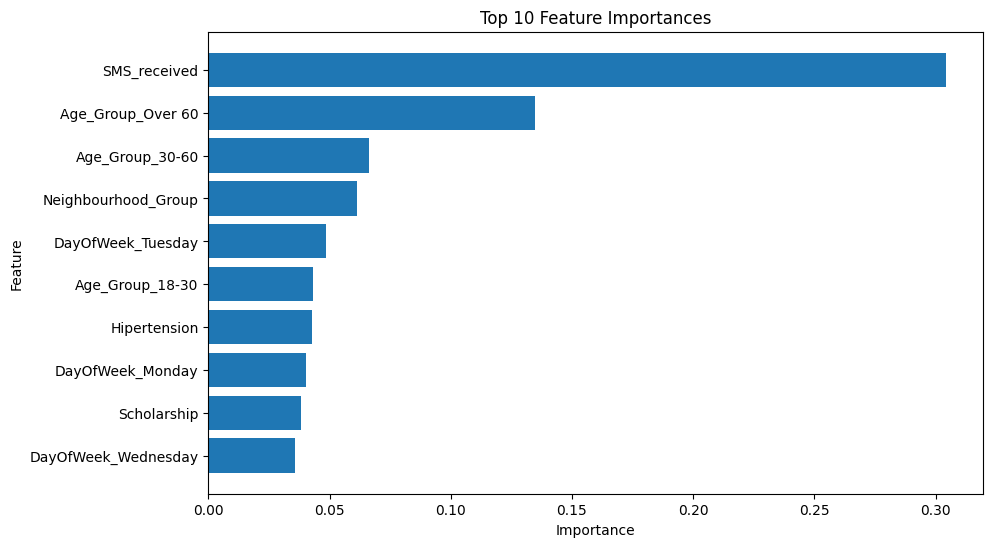

In [102]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importance scores
feature_importance = best_model.feature_importances_

# Map feature importance to feature names
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Display the importance DataFrame
print(importance_df)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10][::-1], importance_df['Importance'][:10][::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances')
plt.show()


### Observations and Recommendations:
1. SMS Reminders Are Crucial:
  * The high importance of SMS_received underscores the effectiveness of reminder systems in improving attendance rates.
  *  Actionable Insight: Healthcare providers should invest in robust reminder systems (e.g., SMS, phone calls) to reduce no-show rates.

2. Age Groups Require Targeted Interventions:
  * Older patients (Over 60) and middle-aged patients (30-60) are relatively predictable, but strategies should focus on improving attendance among younger patients (18-30).
  * Actionable Insight: Tailored outreach programs for younger individuals, such as flexible scheduling or better communication, might improve attendance in this demographic.

3. Geographic Factors Matter:
  * The Neighbourhood_Group feature highlights disparities across regions.
  * Actionable Insight: Analyze specific neighborhoods with low attendance rates to address barriers like transportation or accessibility.

4. Optimize Scheduling by Day:
  * The importance of certain days (e.g., Tuesday) suggests trends in attendance based on the day of the week.
  * Actionable Insight: Identify and allocate resources to days with higher attendance while promoting underutilized days to balance workloads.

### classification report and confussion matrix

In [103]:
# Print evaluation metrics
print("Best Parameters:", random_search.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))
print("\nClassification Report:\n", classification_report(y_test, y_pred_binary))

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}

Confusion Matrix:
 [[10612  7030]
 [ 1934  2530]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.60      0.70     17642
           1       0.26      0.57      0.36      4464

    accuracy                           0.59     22106
   macro avg       0.56      0.58      0.53     22106
weighted avg       0.73      0.59      0.63     22106



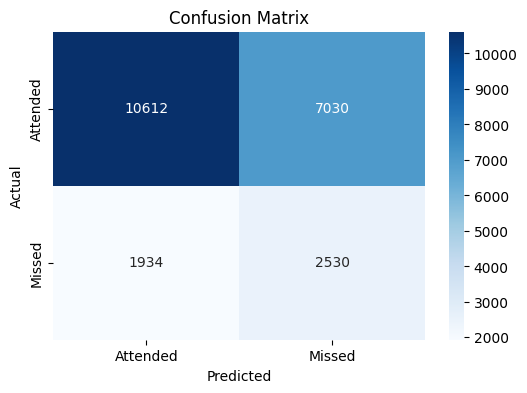

In [104]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Confusion Matrix Plot with Clearer Labels
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Attended', 'Missed'], yticklabels=['Attended', 'Missed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Performance Metrics
1. Confusion Matrix Insights:

*  Positives (Missed correctly predicted): 2,530
*  True Negatives (Attended correctly predicted): 10,612
*  False Positives (Attended predicted as Missed): 7,030
*  False Negatives (Missed predicted as Attended): 1,934

Key Issue: The model struggles to correctly identify missed appointments, evident in the high false positive rate (patients predicted to miss but actually attend).

2. Recall

  * Missed Recall - The model identifies 57% of the missed appointments, an improvement from the previous 6% recall.

  * Attended Recall - The model identifies 60% of the attended cases, it slightly better but still misses a significant portion.

3. Precision

  * Missed Precision - 26%, low precision indicates the model predicts many false positives (patients predicted to miss but actually attend).

  * Attended Precision - 85%, The model is much more precise at predicting attendees.

4. F1 Score

  * For Missed cass - 36%(0.36), Low F1-Score highlights the model's continued struggle with the minority class, still, this better then part 1 model that had 10%(0.1).

### Comparison to Previous Results
  * The recall for the "Missed" class improved from 6% to 57%, indicating the model better identifies no-shows.
  * However, precision for the "Missed" class remains low (26%), meaning the model generates many false positives.
  * Imbalanced data still influences performance, requiring further improvements.

### ROC-AUC

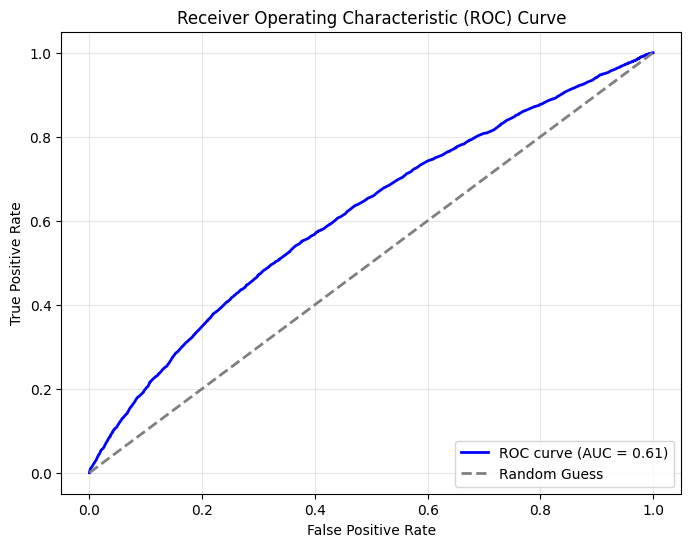

In [105]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate predicted probabilities
y_pred_prob = best_model.predict(X_test)

# Compute ROC curve and ROC area for the "Missed" class (label = 1)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


1. AUC (Area Under the Curve):

  * The AUC score is 0.61, indicating that the model's ability to distinguish between the "Attended" and "Missed" classes is slightly better than random guessing (AUC = 0.5).
  * However, it suggests that the model's overall predictive power is weak and can be improved.

2. True Positive Rate (TPR) vs. False Positive Rate (FPR):

  * The curve indicates how well the model balances between correctly identifying "Missed" cases (sensitivity) and incorrectly predicting "Missed" for "Attended" cases (false positives).
  *  A steep rise in the TPR at lower FPR values would indicate strong performance, but this plot shows a gradual rise, suggesting limited model sensitivity.

3. Key Observations:

  * The model is not effective in accurately predicting the minority class (Missed appointments), likely due to the class imbalance in the dataset.
  * This aligns with earlier findings, where the recall and precision for the "Missed" class were suboptimal.

## 4. Drawing Conclusions About the Data & Creative Applications

1.Feature Significance
  * Top Features:

    * SMS_received: The most influential feature, significantly impacting whether patients attend their appointments. This highlights the critical role of reminders.
    * Age_Group_Over 60: Older patients are more likely to attend, showing age as a strong predictor of attendance behavior.
    * Neighbourhood_Group: Geographic factors influence attendance, suggesting socio-economic or accessibility barriers.
    * DayOfWeek_Tuesday: Attendance patterns vary by the day of the week, with Tuesday showing more importance than other days.

  * Less Important Features:

    * Scholarship has limited influence, indicating financial aid may not directly correlate with attendance.
    * Hipertension plays a minor role despite being a common chronic condition, which could indicate better management by such patients.

We already Data Insights in [previous part](https://colab.research.google.com/drive/1SeJBEso-ZjNWpdQ33dLuI07pOCDoHu1r#scrollTo=uy_LS1S0MDJX) of this notebook

2.Biases or Trends
* Class Imbalance:

  * The dataset's bias toward "Attended" cases affects model predictions, as seen in the confusion matrix and AUC score. Although recall for the "Missed" class improved, the model struggles with precision for this group.

* Age Group Trends:

  * Younger patients (18-30) are less predictable, with lower feature importance. Strategies targeting this demographic could improve attendance.

* Geographic Disparities:

    * The importance of Neighbourhood_Group suggests attendance is influenced by location-based factors such as transport, clinic accessibility, or socio-economic barriers.
    
3.User-Friendly Narrative

This analysis reveals that timely SMS reminders, age, and geographic factors are key drivers of appointment attendance. Older patients are more likely to attend, whereas younger demographics present challenges. Additionally, attendance trends vary by day, with Tuesday showing higher importance.

4.Potential Applications

1. Improving Patient Engagement:

  * Implement enhanced reminder systems (e.g., SMS, phone calls, or email) targeting younger patients to reduce no-shows.
2. Geographic Accessibility Programs:

  * Identify neighborhoods with low attendance and explore solutions like mobile clinics or transportation assistance.

5.Improvements Made and Their Impact
1. Feature Engineering:

  * Simplified categorical features (Neighbourhood_Group) with Label Encoding for computational efficiency.
  * Introduced meaningful age groups (Age_Group) to capture attendance patterns by demographic.
  * Impact: Improved model interpretability and highlighted actionable insights (e.g., reminders and neighborhood disparities).
2. Class Imbalance Handling (SMOTE):

  * Applied SMOTE to balance the dataset, increasing the model's ability to detect "Missed" cases.
  * Impact: Recall for "Missed" improved from 6% to 57%, significantly enhancing sensitivity.
3. Model Optimization:

  * Used hyperparameter tuning to refine the XGBoost model for better performance.
  * Impact: Improved overall classification performance, as reflected in the confusion matrix and ROC-AUC (0.61).

